In [1]:
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../data/raw/customer_support_dataset.csv")


In [3]:
df.sample(10)

,flags,instruction,category,intent,response
20267,BLQZ,I'm trying to recover the pwd of my use,ACCOUNT,recover_password,Of course! I understand that you're attempting...
621,B,I want assistance canceling order {{Order Numb...,ORDER,cancel_order,I'm fully aware that you're seeking assistance...
24570,BLQZ,need help canging to the {{Account Category}} ...,ACCOUNT,switch_account,For sure! I'm here to walk you through the pro...
20477,BILZ,ius it possible to recover my user account key?,ACCOUNT,recover_password,Sure! I'm here to support you in the process o...
19247,BLM,I am trying to order several of your item,ORDER,place_order,Thank you for reaching out! I appreciate your ...
6863,BL,show me in which cases can I ask for refunds,REFUND,check_refund_policy,I'll make it happen! I completely understand y...
4082,BIL,where can I look for the bill #85632?,INVOICE,check_invoice,I've realized that you need assistance with lo...
23478,BIL,where do I submit the new shipping address?,SHIPPING,set_up_shipping_address,I'm sympathetic to your situation that you're ...
25811,BL,show me order {{Order Number}} current status,ORDER,track_order,Thank you for contacting! I certainly recogniz...
3661,BEL,I do not know how to check the cancellation ch...,CANCEL,check_cancellation_fee,No problem! I can assist you with checking the...


In [4]:
df = df.drop(columns=["response", "flags"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26872 entries, 0 to 26871
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   instruction  26872 non-null  object
 1   category     26872 non-null  object
 2   intent       26872 non-null  object
dtypes: object(3)
memory usage: 629.9+ KB


### Data cleaning and Transformation

In [6]:
df["instruction"].head(10)

0     question about cancelling order {{Order Number}}
1    i have a question about cancelling oorder {{Or...
2      i need help cancelling puchase {{Order Number}}
3           I need to cancel purchase {{Order Number}}
4    I cannot afford this order, cancel purchase {{...
5       can you help me cancel order {{Order Number}}?
6    I can no longer afford order {{Order Number}},...
7      I am trying to cancel purchase {{Order Number}}
8       I have got to cancel purchase {{Order Number}}
9      i need help canceling purchase {{Order Number}}
Name: instruction, dtype: object

In [7]:
import re

def clean_instruction(text):
    if pd.isna(text):
        return text

    text = str(text).lower()

    # Remove {{placeholders}}
    text = re.sub(r"\{\{.*?\}\}", " ", text)

    # Remove hash-number patterns like #12345
    text = re.sub(r"#\d+", " ", text)

    # Remove standalone numbers
    text = re.sub(r"\d+", " ", text)

    # Remove extra spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


# Apply cleaning to instruction column
df["instruction"] = df["instruction"].apply(clean_instruction)


In [8]:
# Lowercase all values in category column
df["category"] = df["category"].astype(str).str.lower().str.strip()

# Lowercase intent column and remove underscores
df["intent"] = (
    df["intent"]
    .astype(str)
    .str.lower()
    .str.replace("_", " ", regex=False)
    .str.strip()
)


In [9]:
df= df.rename(columns={
    "instruction": "User Query",
    "category": "Assigned Team",
    "intent": "User Intent"
})


In [10]:
df = df.drop(df[df["User Intent"] == "check cancellation fee"].index)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25922 entries, 0 to 26871
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   User Query     25922 non-null  object
 1   Assigned Team  25922 non-null  object
 2   User Intent    25922 non-null  object
dtypes: object(3)
memory usage: 810.1+ KB


In [12]:
df["Assigned Team"].value_counts()

Assigned Team
account         5986
order           3988
refund          2992
contact         1999
invoice         1999
payment         1998
feedback        1997
delivery        1994
shipping        1970
subscription     999
Name: count, dtype: int64

In [13]:
df["Assigned Team"].unique()

array(['order', 'shipping', 'invoice', 'payment', 'refund', 'feedback',
       'contact', 'account', 'delivery', 'subscription'], dtype=object)

In [16]:
df["User Intent"].unique()

array(['cancel order', 'change order', 'change shipping address',
       'check invoice', 'check payment methods', 'check refund policy',
       'complaint', 'contact customer service', 'contact human agent',
       'create account', 'delete account', 'delivery options',
       'delivery period', 'edit account', 'get invoice', 'get refund',
       'newsletter subscription', 'payment issue', 'place order',
       'recover password', 'registration problems', 'review',
       'set up shipping address', 'switch account', 'track order',
       'track refund'], dtype=object)

In [17]:
df['User Intent'].value_counts()

User Intent
complaint                   1000
check invoice               1000
contact customer service    1000
edit account                1000
switch account              1000
check payment methods        999
delivery period              999
newsletter subscription      999
contact human agent          999
payment issue                999
registration problems        999
get invoice                  999
place order                  998
track refund                 998
cancel order                 998
create account               997
check refund policy          997
change order                 997
get refund                   997
set up shipping address      997
review                       997
delivery options             995
recover password             995
delete account               995
track order                  995
change shipping address      973
Name: count, dtype: int64

In [18]:
df.columns

Index(['User Query', 'Assigned Team', 'User Intent'], dtype='object')

In [19]:
# Normalize User Intent text
df["User Intent"] = (
    df["User Intent"]
    .astype(str)
    .str.lower()
    .str.strip()
)

# intent → assigned team mapping
intent_to_team = {
    "place order": "order team",
    "change order": "order team",
    "cancel order": "order team",

    "track order": "delivery team",
    "change shipping address": "delivery team",
    "set up shipping address": "delivery team",
    "delivery options": "delivery team",
    "delivery period": "delivery team",

    "payment issue": "payment team",
    "check payment methods": "payment team",
    "get invoice": "payment team",
    "check invoice": "payment team",

    "get refund": "refund team",
    "check refund policy": "refund team",
    "track refund": "refund team",

    "create account": "account team",
    "edit account": "account team",
    "delete account": "account team",
    "switch account": "account team",
    "recover password": "account team",
    "registration problems": "account team",

    "complaint": "support team",
    "review": "support team",
    "contact customer service": "support team",
    "contact human agent": "support team",

    "newsletter subscription": "subscription team"
}

# Apply mapping FROM User Intent TO Assigned Team
df["Assigned Team"] = (
    df["User Intent"]
    .map(intent_to_team)
    .fillna("unknown")
)


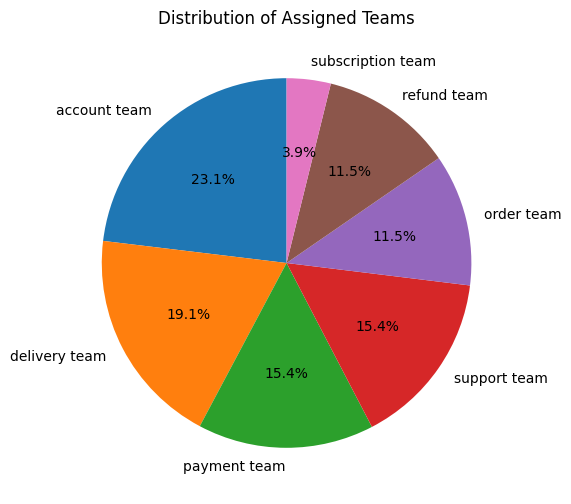

In [20]:
import matplotlib.pyplot as plt

df['Assigned Team'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    figsize=(6, 6)
)

plt.ylabel("")   # removes default y-label
plt.title("Distribution of Assigned Teams")
plt.show()


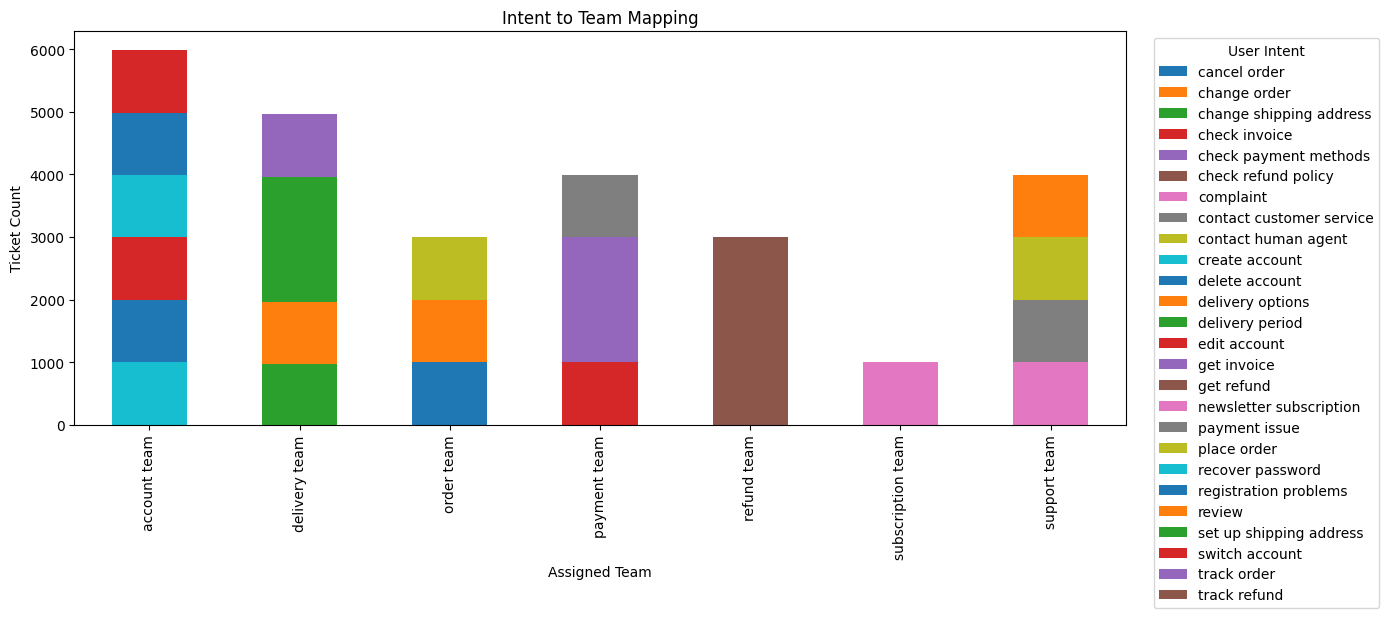

In [23]:
ct = pd.crosstab(df["Assigned Team"], df["User Intent"])

ax = ct.plot(
    kind="bar",
    stacked=True,
    figsize=(14, 6)
)

ax.set_title("Intent to Team Mapping")
ax.set_xlabel("Assigned Team")
ax.set_ylabel("Ticket Count")

# 🔥 Move legend outside
plt.legend(
    title="User Intent",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


In [ ]:
df.shape

(25922, 3)

In [ ]:
df.to_csv("../data/processed/cleaned_dataset.csv", index=False)